In [1]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_17174/3358762314.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  input=input.fillna(method='bfill').fillna(method='ffill')


In [6]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_17174/2250321558.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_dam

Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 04:41:20.603226: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_16/Assign' id:7287 op device:{requested: '', assigned: ''} def:{{{node true_positives_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_16, true_positives_16/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 04:41:26.289553: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_7/mul' id:7573 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 04:50:32.478594: W tensorflow/c/c_api.cc:304] Operation '{name:'training_12/Adam/dense_6/bias/m/Assign' id:9813 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_6/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_6/bias/m, training_12/Adam/dense_6/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 04:50:38.601674: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_9/mul' id:9242 op


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 04:59:36.479420: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_15/Assign' id:10209 op device:{requested: '', assigned: ''} def:{{{node false_positives_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_15, false_positives_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 04:59:42.067939: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_10/mul' id:10475 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:08:20.730127: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_16/Assign' id:11427 op device:{requested: '', assigned: ''} def:{{{node false_negatives_16/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_16, false_negatives_16/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:08:26.897224: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_11/mul' id:11708 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:17:23.252911: W tensorflow/c/c_api.cc:304] Operation '{name:'true_negatives_9/Assign' id:12670 op device:{requested: '', assigned: ''} def:{{{node true_negatives_9/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_9, true_negatives_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:17:29.112434: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_12/mul' id:12941 op device:{requested: '', assigned: ''} def:{{{node loss_12


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:26:20.465848: W tensorflow/c/c_api.cc:304] Operation '{name:'training_20/Adam/iter/Assign' id:14701 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_20/Adam/iter, training_20/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:26:26.418928: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_13/mul' id:14174 op device:{requested: '', assigned: ''}


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:35:17.594549: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_11/kernel/Assign' id:15096 op device:{requested: '', assigned: ''} def:{{{node dense_11/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_11/kernel, dense_11/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:35:23.618905: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_14/mul' id:15407 op device:{requested: '', assigned: ''} def:{{{node lo


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:44:23.139878: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_38/Assign' id:16364 op device:{requested: '', assigned: ''} def:{{{node true_positives_38/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_38, true_positives_38/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:44:29.041483: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_15/mul' id:16640 op device:{requested: '', assigned: ''} def:{{{node los


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 05:53:15.545083: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_13/lstm_cell/kernel/Assign' id:17369 op device:{requested: '', assigned: ''} def:{{{node lstm_13/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_13/lstm_cell/kernel, lstm_13/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 05:53:21.365623: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_16/mul' id:17873 op device:{request


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-05 06:01:51.763251: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_42/Assign' id:18810 op device:{requested: '', assigned: ''} def:{{{node true_positives_42/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_42, true_positives_42/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:01:58.014312: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_17/mul' id:19106 op device:{requested: '', assigned: ''} def:{{{node los


📊 Average metrics for schedule 'Convex Only': {'loss': 0.16302755051021336, 'accuracy': 0.5971835, 'precision': 0.6065408, 'recall': 0.6179096, 'f1': 0.6009788936586654, 'auc': 0.6728574378686558}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:10:43.060456: W tensorflow/c/c_api.cc:304] Operation '{name:'training_30/Adam/lstm_15/lstm_cell/kernel/v/Assign' id:20917 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/lstm_15/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/lstm_15/lstm_cell/kernel/v, training_30/Adam/lstm_15/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:10:49.110787: W tensorflow/c/c_api


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:11:38.334577: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_32/Assign' id:21058 op device:{requested: '', assigned: ''} def:{{{node false_positives_32/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_32, false_positives_32/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:11:44.434629: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_19/mul' id:21351 op device:{requested: '', assigned: ''} def:{{{node loss_19/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_19/mul/x, loss_19/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 06:15:12.416591: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_52/Assign' id:22004 op device:{requested: '', assigned: ''} def:{{{node true_positives_52/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_52, true_positives_52/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:15:18.392838: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_20/mul' id:22292 op device:{requested: '', assigned: ''} def:{{{node loss_20/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_20/mul/x, loss_20/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:19:43.680007: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_16/bias/Assign' id:23586 op device:{requested: '', assigned: ''} def:{{{node dense_16/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_16/bias, dense_16/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:19:49.752588: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_22/mul' id:23892 op device:{requested: '', assigned: ''} def:{{{node loss_22/mul}} = Mul


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:20:37.112580: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_39/Assign' id:24641 op device:{requested: '', assigned: ''} def:{{{node false_negatives_39/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_39, false_negatives_39/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:20:43.138446: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_23/mul' id:24904 op device:{requested: '', assigned: ''} def:{{{node loss_23/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_23/mul/x, loss_23/dense_16_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 06:24:08.352200: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_41/Assign' id:25577 op device:{requested: '', assigned: ''} def:{{{node false_positives_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_41, false_positives_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:24:14.680919: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_24/mul' id:25845 op device:{requested: '', assigned: ''} def:{{{node loss_24/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_24/mul/x, loss_24/dense_16_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


📂 Fold 3/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:28:36.598872: W tensorflow/c/c_api.cc:304] Operation '{name:'training_42/Adam/lstm_17/lstm_cell/kernel/v/Assign' id:27585 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/lstm_17/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/lstm_17/lstm_cell/kernel/v, training_42/Adam/lstm_17/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:28:42.866080: W tensorflow/c/c_api


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:29:30.343411: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_67/Assign' id:27731 op device:{requested: '', assigned: ''} def:{{{node true_positives_67/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_67, true_positives_67/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:29:36.583662: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_26/mul' id:28019 op device:{requested: '', assigned: ''} def:{{{node loss_26/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_26/mul/x, loss_26/dense_17_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 06:33:10.801493: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_46/Assign' id:28677 op device:{requested: '', assigned: ''} def:{{{node false_negatives_46/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_46, false_negatives_46/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:33:17.660362: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_27/mul' id:28960 op device:{requested: '', assigned: ''} def:{{{node loss_27/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_27/mul/x, loss_27/dense_17_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


📂 Fold 4/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:37:53.147651: W tensorflow/c/c_api.cc:304] Operation '{name:'training_48/Adam/lstm_18/lstm_cell/bias/m/Assign' id:30683 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/lstm_18/lstm_cell/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/lstm_18/lstm_cell/bias/m, training_48/Adam/lstm_18/lstm_cell/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:37:59.667707: W tensorflow/c/c_api.cc:304]


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:38:50.284604: W tensorflow/c/c_api.cc:304] Operation '{name:'count_25/Assign' id:30882 op device:{requested: '', assigned: ''} def:{{{node count_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_25, count_25/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:38:56.880530: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_29/mul' id:31134 op device:{requested: '', assigned: ''} def:{{{node loss_29/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_29/mul/x, loss_29/dense_18_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 06:42:26.585193: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_79/Assign' id:31787 op device:{requested: '', assigned: ''} def:{{{node true_positives_79/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_79, true_positives_79/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:42:33.116352: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_30/mul' id:32075 op device:{requested: '', assigned: ''} def:{{{node loss_30/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_30/mul/x, loss_30/dense_18_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


📂 Fold 5/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:46:59.619503: W tensorflow/c/c_api.cc:304] Operation '{name:'training_54/Adam/lstm_19/lstm_cell/kernel/v/Assign' id:33815 op device:{requested: '', assigned: ''} def:{{{node training_54/Adam/lstm_19/lstm_cell/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_54/Adam/lstm_19/lstm_cell/kernel/v, training_54/Adam/lstm_19/lstm_cell/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:47:06.440789: W tensorflow/c/c_api


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:47:56.545328: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_85/Assign' id:33961 op device:{requested: '', assigned: ''} def:{{{node true_positives_85/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_85, true_positives_85/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:48:03.371819: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_32/mul' id:34249 op device:{requested: '', assigned: ''} def:{{{node loss_32/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_32/mul/x, loss_32/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 06:51:45.981306: W tensorflow/c/c_api.cc:304] Operation '{name:'count_29/Assign' id:34938 op device:{requested: '', assigned: ''} def:{{{node count_29/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_29, count_29/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:51:52.582188: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_33/mul' id:35190 op device:{requested: '', assigned: ''} def:{{{node loss_33/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_33/mul/x, loss_33/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 6/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 06:56:16.259091: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_20/lstm_cell/recurrent_kernel/Assign' id:35868 op device:{requested: '', assigned: ''} def:{{{node lstm_20/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_20/lstm_cell/recurrent_kernel, lstm_20/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 06:56:23.004748: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_34/m


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 06:57:13.756307: W tensorflow/c/c_api.cc:304] Operation '{name:'total_31/Assign' id:37107 op device:{requested: '', assigned: ''} def:{{{node total_31/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_31, total_31/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 06:57:20.492429: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_35/mul' id:37364 op device:{requested: '', assigned: ''} def:{{{node loss_35/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_35/mul/x, loss_35/dense_20_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 07:00:42.890928: W tensorflow/c/c_api.cc:304] Operation '{name:'total_32/Assign' id:38048 op device:{requested: '', assigned: ''} def:{{{node total_32/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_32, total_32/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:00:49.476945: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_36/mul' id:38305 op device:{requested: '', assigned: ''} def:{{{node loss_36/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_36/mul/x, loss_36/dense_20_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 7/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 07:05:08.313953: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_21/lstm_cell/bias/Assign' id:38992 op device:{requested: '', assigned: ''} def:{{{node lstm_21/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_21/lstm_cell/bias, lstm_21/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 07:05:15.528488: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_37/mul' id:39467 op device:{requested: '', assigned


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 07:06:05.036501: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_104/Assign' id:40201 op device:{requested: '', assigned: ''} def:{{{node true_positives_104/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_104, true_positives_104/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:06:11.878865: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_38/mul' id:40479 op device:{requested: '', assigned: ''} def:{{{node loss_38/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_38/mul/x, loss_38/dense_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 07:09:49.577745: W tensorflow/c/c_api.cc:304] Operation '{name:'count_35/Assign' id:41168 op device:{requested: '', assigned: ''} def:{{{node count_35/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_35, count_35/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:09:56.396934: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_39/mul' id:41420 op device:{requested: '', assigned: ''} def:{{{node loss_39/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_39/mul/x, loss_39/dense_21_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 8/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 07:14:19.517110: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_22/kernel/Assign' id:42271 op device:{requested: '', assigned: ''} def:{{{node dense_22/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_22/kernel, dense_22/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 07:14:26.470087: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_40/mul' id:42582 op device:{requested: '', assigned: ''} def:{{{node lo


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 07:15:16.171751: W tensorflow/c/c_api.cc:304] Operation '{name:'count_37/Assign' id:43342 op device:{requested: '', assigned: ''} def:{{{node count_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_37, count_37/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:15:22.998128: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_41/mul' id:43594 op device:{requested: '', assigned: ''} def:{{{node loss_41/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_41/mul/x, loss_41/dense_22_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 07:18:47.521035: W tensorflow/c/c_api.cc:304] Operation '{name:'total_38/Assign' id:44278 op device:{requested: '', assigned: ''} def:{{{node total_38/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_38, total_38/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:18:54.427453: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_42/mul' id:44535 op device:{requested: '', assigned: ''} def:{{{node loss_42/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_42/mul/x, loss_42/dense_22_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 9/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 07:23:15.567460: W tensorflow/c/c_api.cc:304] Operation '{name:'training_78/Adam/lstm_23/lstm_cell/recurrent_kernel/m/Assign' id:46253 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/lstm_23/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/lstm_23/lstm_cell/recurrent_kernel/m, training_78/Adam/lstm_23/lstm_cell/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 07:24:11.746906: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_120/Assign' id:46411 op device:{requested: '', assigned: ''} def:{{{node true_positives_120/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_120, true_positives_120/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:24:18.741496: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_44/mul' id:46709 op device:{requested: '', assigned: ''} def:{{{node loss_44/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_44/mul/x, loss_44/dense_23_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after run


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 07:27:47.426902: W tensorflow/c/c_api.cc:304] Operation '{name:'count_41/Assign' id:47398 op device:{requested: '', assigned: ''} def:{{{node count_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_41, count_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 07:27:54.642439: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_45/mul' id:47650 op device:{requested: '', assigned: ''} def:{{{node loss_45/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_45/mul/x, loss_45/dense_23_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📂 Fold 10/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-05 07:38:39.415570: W tensorflow/c/c_api.cc:304] Operation '{name:'training_84/Adam/beta_1/Assign' id:49344 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_84/Adam/beta_1, training_84/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 08:13:36.785018: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_46/mul' id:48812 op device:{requested: '


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-05 08:20:56.256030: W tensorflow/c/c_api.cc:304] Operation '{name:'total_43/Assign' id:49567 op device:{requested: '', assigned: ''} def:{{{node total_43/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_43, total_43/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 08:21:05.394643: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_47/mul' id:49824 op device:{requested: '', assigned: ''} def:{{{node loss_47/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_47/mul/x, loss_47/dense_24_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 08:25:47.298414: W tensorflow/c/c_api.cc:304] Operation '{name:'count_44/Assign' id:50513 op device:{requested: '', assigned: ''} def:{{{node count_44/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_44, count_44/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-05 08:25:56.985736: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_48/mul' id:50765 op device:{requested: '', assigned: ''} def:{{{node loss_48/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_48/mul/x, loss_48/dense_24_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/User


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.04113374910729973, 'accuracy': 0.6287025, 'precision': 0.6260225, 'recall': 0.65834725, 'f1': 0.6351436499199252, 'auc': 0.6894465119204949}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 08:31:20.930972: W tensorflow/c/c_api.cc:304] Operation '{name:'training_90/Adam/decay/Assign' id:52497 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_90/Adam/decay, training_90/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 08:31:30.718158: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_49/mul' id:51929 op device:{requested: '', a

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 08:42:36.075514: W tensorflow/c/c_api.cc:304] Operation '{name:'training_92/Adam/dense_26/kernel/m/Assign' id:54220 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/dense_26/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/dense_26/kernel/m, training_92/Adam/dense_26/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 08:42:45.501356: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_51/m


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 08:53:35.882816: W tensorflow/c/c_api.cc:304] Operation '{name:'training_94/Adam/dense_27/bias/v/Assign' id:55515 op device:{requested: '', assigned: ''} def:{{{node training_94/Adam/dense_27/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_94/Adam/dense_27/bias/v, training_94/Adam/dense_27/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 08:53:45.675862: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_52/mul' id:5


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 09:04:20.587020: W tensorflow/c/c_api.cc:304] Operation '{name:'training_96/Adam/lstm_28/lstm_cell/bias/m/Assign' id:56737 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/lstm_28/lstm_cell/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/lstm_28/lstm_cell/bias/m, training_96/Adam/lstm_28/lstm_cell/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 09:04:30.510578: W tensorflow/c/c_api.cc:304]


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 09:15:05.028648: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_29/bias/Assign' id:57103 op device:{requested: '', assigned: ''} def:{{{node dense_29/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_29/bias, dense_29/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 09:15:14.900976: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_54/mul' id:57411 op device:{requested: '', assigned: ''} def:{{{node loss_54/mul}} = Mul


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 09:26:06.043545: W tensorflow/c/c_api.cc:304] Operation '{name:'training_100/Adam/dense_30/kernel/m/Assign' id:59264 op device:{requested: '', assigned: ''} def:{{{node training_100/Adam/dense_30/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_100/Adam/dense_30/kernel/m, training_100/Adam/dense_30/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 09:26:16.277309: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 09:37:03.775883: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_31/bias/Assign' id:59625 op device:{requested: '', assigned: ''} def:{{{node dense_31/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_31/bias, dense_31/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 09:37:14.071196: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_56/mul' id:59933 op device:{requested: '', assigned: ''} def:{{{node loss_56/mul}} = Mul


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 09:47:54.700244: W tensorflow/c/c_api.cc:304] Operation '{name:'training_104/Adam/lstm_32/lstm_cell/bias/v/Assign' id:61810 op device:{requested: '', assigned: ''} def:{{{node training_104/Adam/lstm_32/lstm_cell/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_104/Adam/lstm_32/lstm_cell/bias/v, training_104/Adam/lstm_32/lstm_cell/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 09:48:05.238339: W tensorflow/c/c_api.cc:


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 10:02:56.226384: W tensorflow/c/c_api.cc:304] Operation '{name:'true_positives_161/Assign' id:62177 op device:{requested: '', assigned: ''} def:{{{node true_positives_161/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_161, true_positives_161/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 10:03:06.027225: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_58/mul' id:62455 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-05 10:16:24.263002: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_34/lstm_cell/bias/Assign' id:63239 op device:{requested: '', assigned: ''} def:{{{node lstm_34/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_34/lstm_cell/bias, lstm_34/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 10:16:34.938089: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_59/mul' id:63716 op device:{requested: '', assigned


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.1642610106739817, 'accuracy': 0.5910285, 'precision': 0.59182435, 'recall': 0.61104167, 'f1': 0.5937276457856167, 'auc': 0.6642201609299628}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 10:27:24.099251: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_35/lstm_cell/kernel/Assign' id:64471 op device:{requested: '', assigned: ''} def:{{{node lstm_35/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_35/lstm_cell/kernel, lstm_35/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 10:27:35.071590: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_60/mul' id:64977 op device:{request

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 10:39:01.483929: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_36/lstm_cell/kernel/Assign' id:66170 op device:{requested: '', assigned: ''} def:{{{node lstm_36/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_36/lstm_cell/kernel, lstm_36/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 10:39:12.485363: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_62/mul' id:66676 op device:{request


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 10:50:20.687305: W tensorflow/c/c_api.cc:304] Operation '{name:'false_negatives_114/Assign' id:67654 op device:{requested: '', assigned: ''} def:{{{node false_negatives_114/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_114, false_negatives_114/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 10:50:31.767322: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_63/mul' id:67937 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:01:11.538619: W tensorflow/c/c_api.cc:304] Operation '{name:'training_116/Adam/dense_38/kernel/m/Assign' id:69790 op device:{requested: '', assigned: ''} def:{{{node training_116/Adam/dense_38/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_116/Adam/dense_38/kernel/m, training_116/Adam/dense_38/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:01:22.051244: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:12:16.828549: W tensorflow/c/c_api.cc:304] Operation '{name:'training_118/Adam/decay/Assign' id:71027 op device:{requested: '', assigned: ''} def:{{{node training_118/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_118/Adam/decay, training_118/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:12:27.909704: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_65/mul' id:70459 op device:{requested: '


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:22:02.434611: W tensorflow/c/c_api.cc:304] Operation '{name:'training_120/Adam/dense_40/bias/v/Assign' id:72346 op device:{requested: '', assigned: ''} def:{{{node training_120/Adam/dense_40/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_120/Adam/dense_40/bias/v, training_120/Adam/dense_40/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:22:10.517653: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_66/mul' 


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:30:59.248376: W tensorflow/c/c_api.cc:304] Operation '{name:'training_122/Adam/dense_41/bias/m/Assign' id:73578 op device:{requested: '', assigned: ''} def:{{{node training_122/Adam/dense_41/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_122/Adam/dense_41/bias/m, training_122/Adam/dense_41/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:31:07.431995: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_67/mul' 


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:40:09.672885: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_125/Assign' id:73974 op device:{requested: '', assigned: ''} def:{{{node false_positives_125/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_125, false_positives_125/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:40:17.872600: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_68/mul' id:74242 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 11:55:59.785681: W tensorflow/c/c_api.cc:304] Operation '{name:'false_positives_127/Assign' id:75235 op device:{requested: '', assigned: ''} def:{{{node false_positives_127/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_127, false_positives_127/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 11:56:07.726181: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_69/mul' id:75503 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-05 12:04:39.927906: W tensorflow/c/c_api.cc:304] Operation '{name:'training_128/Adam/lstm_44/lstm_cell/bias/m/Assign' id:77351 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/lstm_44/lstm_cell/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/lstm_44/lstm_cell/bias/m, training_128/Adam/lstm_44/lstm_cell/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-05 12:04:48.212568: W tensorflow/c/c_api.cc:


📊 Average metrics for schedule 'Hybrid': {'loss': 0.0411528384784543, 'accuracy': 0.62003165, 'precision': 0.6171587, 'recall': 0.65179265, 'f1': 0.6263627527918565, 'auc': 0.675380631133162}
✅ Metrics exported to 'cross_validation_results_2.csv'


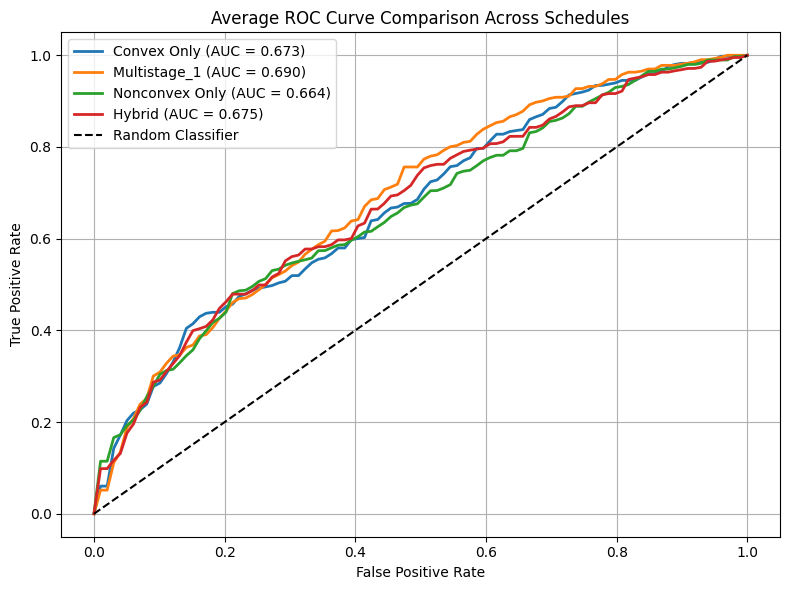

TypeError: Could not convert [array([1.52481535e-05]) array([0.00740209]) array([4.53713991e-07])
 array([9.50171573e-05]) array([0.00321153]) array([2.59070269e-08])
 array([1.03477612e-06]) array([3.22946366e-07]) array([6.6754e-06])
 array([7.96559583e-07]) array([0.00248794]) array([0.00225701])
 array([0.00100782]) array([2.54286894e-07]) array([3.15466414e-07])
 array([1.98202612e-07]) array([2.60274838e-07]) array([4.55056961e-07])
 array([5.03081171e-07]) array([6.68071026e-05]) array([5.34328037e-06])
 array([1.66092476e-07]) array([3.18156641e-07]) array([1.94110045e-07])
 array([1.48772121e-07]) array([0.00082782]) array([0.00097816])
 array([1.59963336e-06]) array([6.85237477e-06])] to numeric

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise






def model_builder():
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=(X_filtered.shape[1], X_filtered.shape[2])),
        tf.keras.layers.LSTM(128),
        #tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

import tensorflow as tf

class ConvexFocalLoss(tf.keras.losses.Loss):
    """
    Convex variant of Focal Loss where (1 - p_t)^γ is fixed per batch.
    """
    def __init__(self, gamma=0.0, alpha=0.25, from_logits=False,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name='convex_focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

        # Compute (1 - p_t)^γ fresh per batch (no persistent tensor)
        fixed_weight = tf.pow(1.0 - p_t, self.gamma)
        loss = - fixed_weight * tf.math.log(tf.clip_by_value(p_t, 1e-7, 1.0))
        return tf.reduce_mean(loss)




convex_focal_loss_fn = ConvexFocalLoss(gamma=2.0, alpha=0.25, from_logits=False)


#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False, alpha=0.25, gamma=2.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=10):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data

def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    model = model_builder()

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

shap_df = shap_df.sort_values("mean", ascending=True)
shap_df.drop("mean", axis=1, inplace=True)


In [12]:
import numpy as np
import pandas as pd

# Suppose shap_feature_importance is a dict of lists or arrays
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)

# Flatten array entries
shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

# Now compute row-wise mean
shap_df["mean"] = shap_df.mean(axis=1, numeric_only=True)

# Save
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")
shap_df.head()



/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_17174/4213904531.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)


,Convex Only,Multistage_1,Nonconvex Only,Hybrid,mean
Feature 0,1.283234e-05,9.549511e-08,1.807230e-06,5.130877e-07,3.812038e-06
Feature 1,5.546595e-03,5.908576e-04,6.321678e-04,6.324719e-04,1.850523e-03
Feature 2,4.140754e-07,4.642799e-10,3.803757e-08,1.136719e-09,1.134285e-07
Feature 3,5.641118e-05,2.977249e-06,2.389267e-05,1.173606e-05,2.375429e-05
Feature 4,8.080983e-04,4.939093e-04,8.604630e-04,1.049057e-03,8.028818e-04


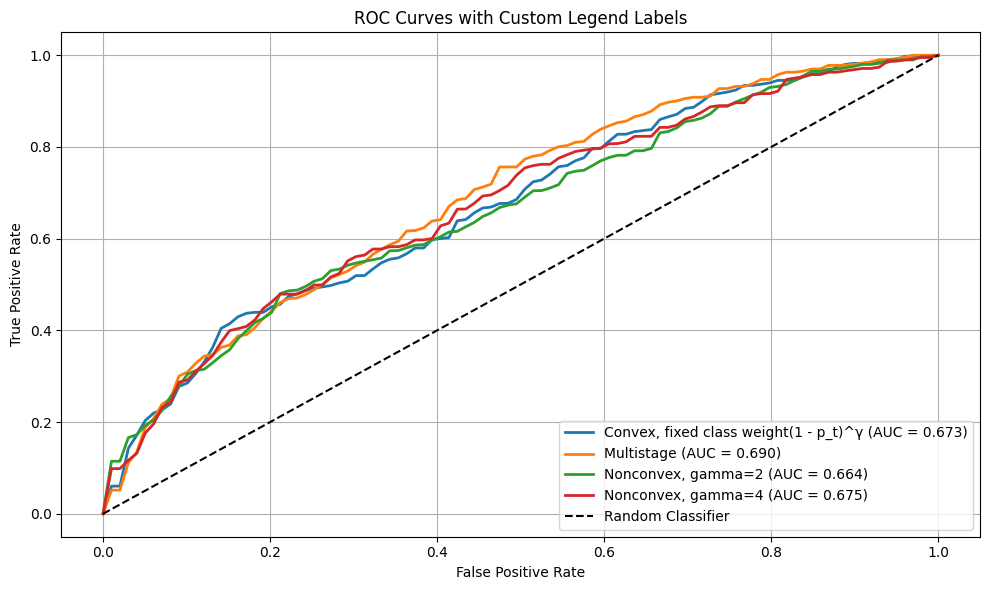

In [16]:
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, fixed class weight(1 - p_t)^γ",
    "Multistage_1": "Multistage",
    "Nonconvex Only": "Nonconvex, gamma=2",
    "Hybrid": "Nonconvex, gamma=4"
}

# === Function to compute average ROC curve ===
import numpy as np
from sklearn.metrics import auc


# === Plot ROC curves ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)
    else:
        print(f"Warning: No ROC data for '{schedule}'")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_custom_legend.png")
plt.show()

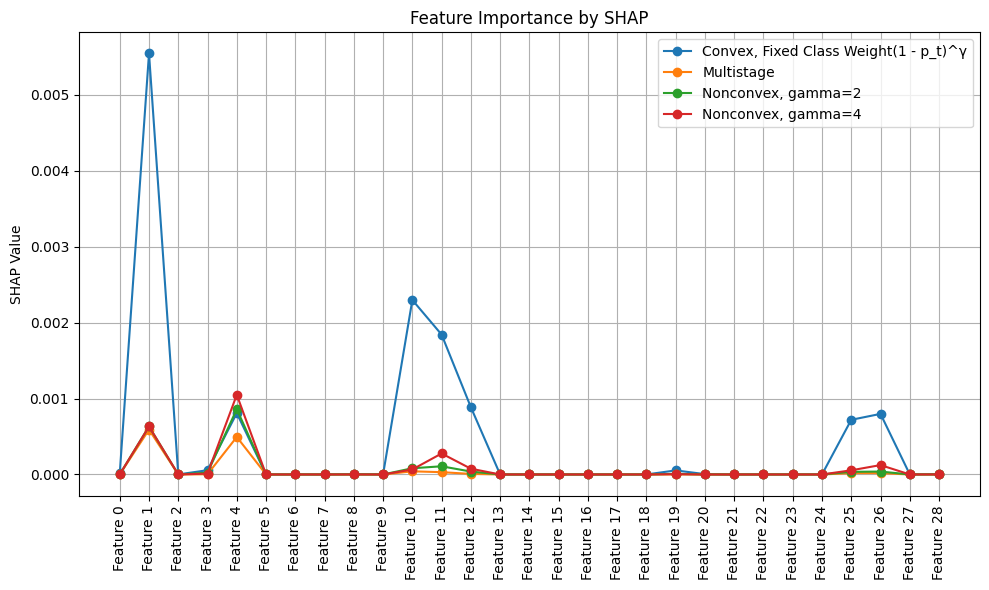

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]

# Editable mapping for custom legend names
legend_labels = {
    "Convex Only": "Convex, Fixed Class Weight(1 - p_t)^γ",
    "Multistage_1": "Multistage",
    "Nonconvex Only": "Nonconvex, gamma=2",
    "Hybrid": "Nonconvex, gamma=4"
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
